<a href="https://colab.research.google.com/github/tural199823/pizza_not_pizza/blob/main/pizza_not_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, Activation
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/pnp.zip

In [9]:
pizza_path = '../content/pizza_not_pizza/pizza'
not_pizza_path = '../content/pizza_not_pizza/not_pizza'
data_dir = '../content/pizza_not_pizza'

In [10]:
num_pizza_images = len(os.listdir(pizza_path))
non_pizza_images = len(os.listdir(not_pizza_path))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


In [ ]:
print(os.getcwd())

/content


In [ ]:
os.listdir(pizza_path)

In [12]:
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 200

In [13]:
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip= True,
                              rotation_range = 20,
                              width_shift_range=0.2,
                              height_shift_range=0.2)

training_images = data_gen.flow_from_directory(data_dir,
                                          target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')

validation_images = data_gen.flow_from_directory(data_dir,
                                          target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size = 32,
                                          subset = 'validation',
                                          class_mode = 'binary')

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [14]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH, 3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3),padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                        

In [24]:
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.88:
            print("\nReached 88% validation accuracy, so stopping training!")
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [16]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
len(training_images)

50

In [25]:
history = model.fit(training_images,
                    validation_data = validation_images,
                    epochs=80,
                    callbacks= [accuracy_callback],
                    verbose=1)

Epoch 1/80
50/50 [==============================] - 32s 642ms/step - loss: 0.2321 - accuracy: 0.9072 - val_loss: 0.5768 - val_accuracy: 0.8138
Epoch 2/80
50/50 [==============================] - 27s 532ms/step - loss: 0.2362 - accuracy: 0.9015 - val_loss: 0.4744 - val_accuracy: 0.8393
Epoch 3/80
50/50 [==============================] - 27s 534ms/step - loss: 0.2399 - accuracy: 0.8990 - val_loss: 0.3779 - val_accuracy: 0.8648
Epoch 4/80
50/50 [==============================] - 27s 533ms/step - loss: 0.2103 - accuracy: 0.9079 - val_loss: 0.4052 - val_accuracy: 0.8546
Epoch 5/80
50/50 [==============================] - 28s 569ms/step - loss: 0.2242 - accuracy: 0.9091 - val_loss: 0.7300 - val_accuracy: 0.7934
Epoch 6/80
50/50 [==============================] - 26s 517ms/step - loss: 0.2492 - accuracy: 0.9028 - val_loss: 0.6421 - val_accuracy: 0.8444
Epoch 7/80
50/50 [==============================] - 27s 533ms/step - loss: 0.2327 - accuracy: 0.9047 - val_loss: 0.4572 - val_accuracy: 0.8495

13/13 - 5s - loss: 0.5246 - accuracy: 0.8418 - 5s/epoch - 398ms/step


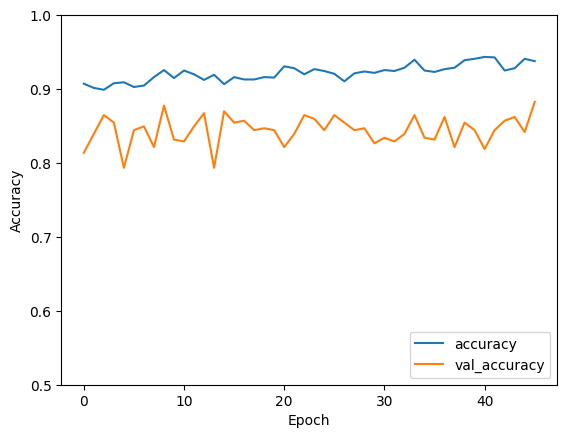

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(validation_images, verbose=2)

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

def load_and_predict(model):
    uploaded_files = files.upload()

    for fn in uploaded_files.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(200,200))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        classes = model.predict(x)
        results = ["a pizza" if score > 0.5 else "not a pizza" for score in classes[0]]

        print(f'The model predicts that the image is {results[0]}')

In [28]:
load_and_predict(model)

Saving salmon-518032_640.jpg to salmon-518032_640 (1).jpg
Saving vegetables-1085063_640.jpg to vegetables-1085063_640 (2).jpg
Saving vegetables-752153_640.jpg to vegetables-752153_640 (1).jpg
Saving soup-4055647_640.jpg to soup-4055647_640 (1).jpg
Saving cake-1971552_640(1).jpg to cake-1971552_640(1) (1).jpg
Saving cake-1850011_640.jpg to cake-1850011_640 (2).jpg
Saving cake-1971552_640.jpg to cake-1971552_640 (1).jpg
Saving spaghetti-1392266_640.jpg to spaghetti-1392266_640 (1).jpg
Saving bulldog-1047518_640.jpg to bulldog-1047518_640 (1).jpg
Saving puppy-1903313_640.jpg to puppy-1903313_640 (1).jpg
Saving dog-1839808_640.jpg to dog-1839808_640 (1).jpg
Saving kitten-4611189_640 (1).jpg to kitten-4611189_640 (1) (1).jpg
Saving cat-1192026_640 (1).jpg to cat-1192026_640 (1) (1).jpg
Saving cat-2083492_640.jpg to cat-2083492_640 (1).jpg
Saving cat-5098930_640.jpg to cat-5098930_640 (1).jpg
1/1 [==============================] - 0s 18ms/step
The model predicts that the image is not a pizza

In [29]:
load_and_predict(model)

Saving pizza-329523_640.jpg to pizza-329523_640.jpg
Saving pizza-2068272_640(1).jpg to pizza-2068272_640(1).jpg
Saving pizza-6478478_640.jpg to pizza-6478478_640.jpg
Saving pizza-397942_640.jpg to pizza-397942_640.jpg
Saving pizza-2589575_640.jpg to pizza-2589575_640 (1).jpg
Saving pizza-1344720_640.jpg to pizza-1344720_640 (2).jpg
Saving pizza-3000285_640.png to pizza-3000285_640 (1).png
Saving pizza-2068272_640.jpg to pizza-2068272_640 (2).jpg
1/1 [==============================] - 0s 29ms/step
The model predicts that the image is a pizza
1/1 [==============================] - 0s 26ms/step
The model predicts that the image is a pizza
1/1 [==============================] - 0s 29ms/step
The model predicts that the image is not a pizza
1/1 [==============================] - 0s 18ms/step
The model predicts that the image is a pizza
1/1 [==============================] - 0s 21ms/step
The model predicts that the image is a pizza
1/1 [==============================] - 0s 19ms/step
The model